# Trying autoencoder
This is the simple and sample code -- without any understanding of what the autoencoder does -- the implementation is a follows:

1. It is used to "compress" the data
2. Learn the "underlying general" carectersitics (fuck the spelling)
3. And the decoder finally "achieves" re-constructs that.

--- OH HELL --- Can we blur the text (encoder) and then retrieve it?

In [1]:
# pip install torch torchvision matplotlib  # if needed

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# ========== Device setup (GPU if available) ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # auto-pick CUDA[48][50]
print("Using device:", device)

Using device: cuda


In [3]:
# ---------- Safe transform (no lambda -> pickleable) ----------
def flatten_tensor(t):
    return t.view(-1)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(flatten_tensor),  # top-level function is pickle-safe[56]
])

In [5]:
# If pickling still complains on some setups, fallback:
# set_workers = 0 to disable multiprocessing loaders[58]
num_workers = 2 if torch.cuda.is_available() else 0

In [6]:
# ========== Data ==========
# MNIST 28x28 -> flatten to 784 in [0,1]

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=0, pin_memory=False, persistent_workers=False)

In [10]:
# ========== Model ==========
class AutoEncoder(nn.Module):
    def __init__(self, in_dim=784, latent=32, linear_hidden=False):
        super().__init__()
        act = nn.Identity if linear_hidden else nn.ReLU
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 256),
            act(),
            nn.Linear(256, latent),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent, 256),
            act(),
            nn.Linear(256, in_dim),
            nn.Sigmoid(),  # images in [0,1]
        )
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

In [16]:
model = AutoEncoder(latent=32, linear_hidden=True).to(device)  # push model to GPU/CPU[48][50]
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [17]:
# ========== Train ==========
epochs = 5
model.train()
for epoch in range(epochs):
    running = 0.0
    for x, _ in train_dl:
        # move batch to device
        x = x.to(device, non_blocking=True)  # ensure data is on GPU[50]
        x_hat, _ = model(x)
        loss = loss_fn(x_hat, x)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        running += loss.item()
    print(f"epoch {epoch+1}/{epochs}  loss {running/len(train_dl):.4f}")

epoch 1/5  loss 0.0502
epoch 2/5  loss 0.0184
epoch 3/5  loss 0.0133
epoch 4/5  loss 0.0114
epoch 5/5  loss 0.0105


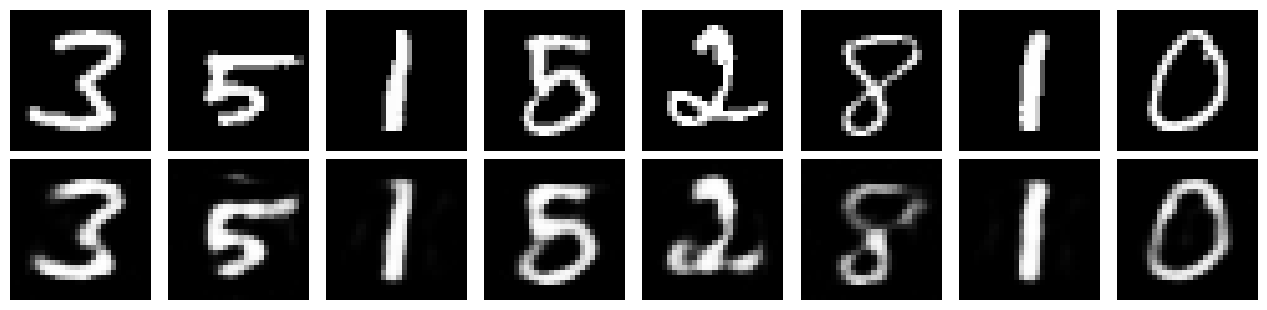

In [18]:
# ========== Visualize before vs after ==========
model.eval()
with torch.no_grad():
    x, _ = next(iter(train_dl))
    x = x.to(device, non_blocking=True)
    x_hat, _ = model(x)

# show N pairs side-by-side
N = 8
fig, axes = plt.subplots(2, N, figsize=(N*1.6, 3.2))
for i in range(N):
    axes[0, i].imshow(x[i].view(28, 28).detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axes[0, i].axis('off')
    axes[1, i].imshow(x_hat[i].view(28, 28).detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axes[1, i].axis('off')
axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Recon', fontsize=12)
plt.tight_layout()
plt.show()

# ========== Extras ==========
# Check CUDA details if curious:
# print(torch.cuda.is_available())  # True if GPU usable[55]
# print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")  # GPU name[52]


In [25]:
#! pip install torchinfo

In [24]:
from torchinfo import summary

In [25]:
# assume `model` from previous cell and device set
# 1) Model summary (like Keras)
print(summary(model, input_size=(1, 784)))  # batch=1, flattened MNIST[78][80]

# 2) Total/trainable parameter counts
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total:,}  |  Trainable: {trainable:,}")  # [75]

# 3) List layer names with tensor shapes
for name, p in model.named_parameters():  # names + shapes + grad flag[77]
    print(f"{name:30s} {tuple(p.shape)}  requires_grad={p.requires_grad}")

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 784]                  --
├─Sequential: 1-1                        [1, 8]                    --
│    └─Linear: 2-1                       [1, 256]                  200,960
│    └─ReLU: 2-2                         [1, 256]                  --
│    └─Linear: 2-3                       [1, 8]                    2,056
├─Sequential: 1-2                        [1, 784]                  --
│    └─Linear: 2-4                       [1, 128]                  1,152
│    └─Linear: 2-5                       [1, 256]                  33,024
│    └─ReLU: 2-6                         [1, 256]                  --
│    └─ReLU: 2-7                         [1, 256]                  --
│    └─Linear: 2-8                       [1, 784]                  201,488
│    └─Sigmoid: 2-9                      [1, 784]                  --
Total params: 438,680
Trainable params: 438,680
Non-trainable par

# 